# Feature Engineering

In [1]:
# Importing necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import numpy as np
from category_encoders.glmm import GLMMEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

### Importing dataset

In [2]:
#Loading dataset saved from EDA
train = pd.read_csv('preprocessed_train_eda.csv')
test = pd.read_csv('preprocessed_test_eda.csv')

## Interaction Features (Numerical)

In [3]:
# Importing top features from the EDA dataset.
rf_col = open('Top-features','rb')
features = pickle.load(rf_col,encoding = 'latin1')

In [4]:
top_features = []
for i in features:
    if i in train.columns:
        top_features.append(i)

In [5]:
#Creating combination of features got from EDA
two_way_list = list(combinations(top_features,2))
three_way_list = list(combinations(top_features,3))

In [6]:
#Creating a dataframe which consists of combinations of features
train_numeric_corr = pd.DataFrame()
def interaction_features(col):
    if len(col) == 2:
        train_numeric_corr[str(col[0])+'_add_'+str(col[1])] = train[col[0]]+train[col[1]]
    else:
        train_numeric_corr[str(col[0])+'_add_'+str(col[1])+'_add_'+str(col[2])] = train[col[0]]+train[col[1]]+train[col[2]]

In [7]:
for i in (two_way_list+three_way_list):
    interaction_features(i)

In [8]:
test_numeric_corr = pd.DataFrame()
def interaction_features(col):
    if len(col) == 2:
        test_numeric_corr[str(col[0])+'_add_'+str(col[1])] = test[col[0]]+test[col[1]]
    else:
        test_numeric_corr[str(col[0])+'_add_'+str(col[1])+'_add_'+str(col[2])] = test[col[0]]+test[col[1]]+test[col[2]]

In [9]:
for i in (two_way_list+three_way_list):
    interaction_features(i)

In [10]:
train_numeric_corr['y'] = train['y']

In [11]:
correlation = train_numeric_corr.corr(method = 'pearson')

In [12]:
corr_values = list(correlation['y'].sort_values(ascending = False))
corr_cols = list(correlation['y'].sort_values(ascending = False).index)

In [13]:
#Selecting correlation features which have correlation greater than 0.68 to target variable from above combinations of features
top_correlated_features = []
for i in range(len(corr_values)):
    if corr_values[i] > 0.68:
        if corr_cols[i] != 'y':
            top_correlated_features.append(corr_cols[i])   

In [14]:
len(top_correlated_features)

19

In [15]:
file = 'Corr-features'
file_dump = open(file,'wb')
pickle.dump(top_correlated_features,file_dump)
file_dump.close()

In [16]:
train_top_corr_numeric = train_numeric_corr[top_correlated_features]
test_top_corr_numeric = test_numeric_corr[top_correlated_features]

## PCA and TSVD for Numerical features

### Creating PCA features

In [17]:
numeric = list(train.select_dtypes(include = 'int64').columns)
numeric_train = train[numeric]
numeric_test = test[numeric]

In [18]:
# Using standard scaler to normalize the data
scaler = StandardScaler()

In [19]:
train_numeric_norm= scaler.fit_transform(numeric_train)

In [20]:
train_numeric_norm = pd.DataFrame(train_numeric_norm,columns = numeric_train.columns)

In [21]:
test_numeric_norm = scaler.transform(numeric_test)

In [22]:
test_numeric_norm = pd.DataFrame(test_numeric_norm,columns = numeric_test.columns)

In [23]:
pca = PCA(n_components = 50)
train_pca = pca.fit(train_numeric_norm)

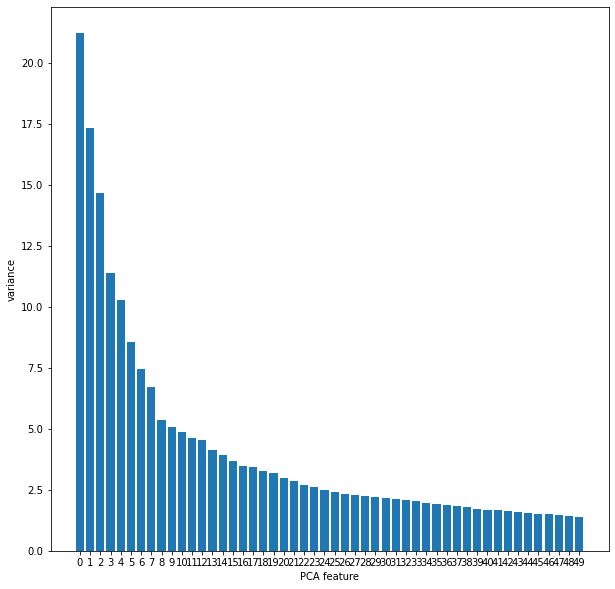

In [24]:
# Plot the explained variances
plt.figure(figsize = (10,10))
features = range(train_pca.n_components_)
plt.bar(features, train_pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

#### From above graph we can take number of components as 6 for PCA

In [25]:
n_comp = 6
pca = PCA(n_components = n_comp)
train_pca = pca.fit_transform(train_numeric_norm)
test_pca = pca.transform(test_numeric_norm)

In [26]:
train_pca_df = pd.DataFrame()
test_pca_df = pd.DataFrame()
for i in range(1,n_comp+1):
    train_pca_df['pca'+str(i)] = train_pca[:,i-1]
    test_pca_df['pca'+str(i)] = test_pca[:,i-1]

In [146]:
filename = 'models/pca.sav'
pickle.dump(pca,open(filename,'wb'))

### Creating TSVD Features

#### Optimal Thresholding of Singular values

In [27]:
## Using Truncated SVD to find the singular values and setting number of components as 100.
svd = TruncatedSVD(n_components = 150,random_state = 42)

In [28]:
train_tsvd = svd.fit_transform(train_numeric_norm)

In [29]:
singular_values = svd.singular_values_

In [30]:
var_explained = svd.explained_variance_ratio_.sum()

##### Using 100 as number of components transformed data from tsvd can explain 95% of our data

In [31]:
var_explained

0.9562972630843092

#### Thresholding of singluar values (https://arxiv.org/pdf/1305.5870.pdf)

In [32]:
def beta_cal(input_matrix):
    m = min(input_matrix.shape)
    n = max(input_matrix.shape)
    return m/n

In [33]:
def optimal_svht_sigma(beta):
    return (0.56*beta**3)-(0.95*beta**2)+(1.82*beta)+1.43

In [34]:
beta = beta_cal(train_numeric_norm)
print('Beta value must be in range of (0,1] and beta value is ',beta)

Beta value must be in range of (0,1] and beta value is  0.07415355269432522


In [35]:
sigma = optimal_svht_sigma(beta)
print('w(beta) coefficient according to the paper is ',sigma)

w(beta) coefficient according to the paper is  1.55996399500429


In [36]:
# Finding median from the singular values generated from the TSVD
sv_median = np.median(singular_values)

In [37]:
# The threshold for the singluar values
threshold = sigma*sv_median

In [38]:
# The number of components we can have in TSVD after thresholding.
n_comp = np.max( np.where( singular_values > threshold ) ) + 1
print('Number of components after thresholding is ',n_comp)

Number of components after thresholding is  23


#### Creating TSVD features from above n_components

In [39]:
tsvd = TruncatedSVD(n_components = n_comp,random_state = 42)

In [40]:
train_tsvd = tsvd.fit_transform(train_numeric_norm)

In [41]:
test_tsvd = tsvd.transform(test_numeric_norm)

In [42]:
train_tsvd_df = pd.DataFrame()
test_tsvd_df = pd.DataFrame()
for i in range(1,n_comp+1):
    train_tsvd_df['tsvd'+str(i)] = train_tsvd[:,i-1]
    test_tsvd_df['tsvd'+str(i)] = test_tsvd[:,i-1]

In [147]:
filename = 'models/tsvd.sav'
pickle.dump(tsvd,open(filename,'wb'))

## Datasets-1 (Label Encoding)

### Label Encoding of Categorical Features

In [44]:
#Loading dataset saved from EDA
train_label = pd.read_csv('preprocessed_train_eda.csv')

In [45]:
test_label = pd.read_csv('preprocessed_test_eda.csv')

In [46]:
categ = list(train_label.select_dtypes(include = 'object').columns)

In [47]:
# Label encoding
def label_encode(tr,te,col_name):
    encoder = LabelEncoder()
    label_encoder = encoder.fit(tr[col_name].values)
    te[col_name] = te[col_name].map(lambda x: 'nill' if x not in label_encoder.classes_ else x)
    label_encoder.classes_ = np.append(label_encoder.classes_, 'nill')
    tr[col_name] = label_encoder.transform(tr[col_name])
    te[col_name] = label_encoder.transform(te[col_name])

In [48]:
# Encoding categorical columns using Label Encoder
for i in categ:
    label_encode(train_label,test_label,i)

In [49]:
train_label.head()

,y,X0,X1,X2,X3,X5,X6,X8,X10,X12,...,X373,X374,X375,X376,X377,X378,X379,X380,X383,X384
0,130.81,32,23,17,0,24,9,14,0,0,...,0,0,0,0,1,0,0,0,0,0
1,88.53,32,21,19,4,28,11,14,0,0,...,0,0,1,0,0,0,0,0,0,0
2,76.26,20,24,34,2,27,9,23,0,0,...,0,0,0,0,0,0,0,0,0,0
3,80.62,20,21,34,5,27,11,4,0,0,...,0,0,0,0,0,0,0,0,0,0
4,78.02,20,23,34,5,12,3,13,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
test_label.head()

,X0,X1,X2,X3,X5,X6,X8,X10,X12,X13,...,X373,X374,X375,X376,X377,X378,X379,X380,X383,X384
0,20,23,34,5,29,0,22,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,40,3,7,0,29,6,24,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,20,23,16,5,29,9,9,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,20,13,34,5,29,11,13,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,43,20,16,2,28,8,12,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [51]:
# Using standard scaler to normalize the data
scaler = StandardScaler()

In [52]:
train_label_norm= scaler.fit_transform(train_label.drop(['y'],axis = 1))

In [53]:
train_columns = train_label.drop(['y'],axis = 1).columns

In [54]:
train_label_norm = pd.DataFrame(train_label_norm,columns = train_columns)

In [55]:
train_label_norm.to_csv('label_encoding/preprocessed_train_norm_label.csv',index = False)

In [56]:
test_label_norm = scaler.transform(test_label)

In [57]:
test_label_norm = pd.DataFrame(test_label_norm,columns = test_label.columns)

In [58]:
test_label_norm.to_csv('label_encoding/preprocessed_test_norm_label.csv',index = False)

### Adding Interaction variables

In [59]:
train_label_corr = pd.concat([train_label,train_top_corr_numeric],axis = 1)
test_label_corr = pd.concat([test_label,test_top_corr_numeric],axis = 1)

In [60]:
# Using standard scaler to normalize the data
scaler = StandardScaler()

In [61]:
train_label_interaction = scaler.fit_transform(train_label_corr.drop(['y'],axis = 1))

In [62]:
train_columns = train_label_corr.drop(['y'],axis = 1).columns

In [63]:
train_label_interaction = pd.DataFrame(train_label_interaction,columns = train_columns)

In [64]:
train_label_interaction.to_csv('label_encoding/preprocessed_train_label_interaction.csv',index = False)

In [65]:
test_label_interaction = scaler.transform(test_label_corr)

In [66]:
test_label_interaction = pd.DataFrame(test_label_interaction,columns = test_label_corr.columns)

In [67]:
test_label_interaction.to_csv('label_encoding/preprocessed_test_label_interaction.csv',index = False)

### Adding PCAand Interaction features

In [68]:
train_label_corr_pca = pd.concat([train_label_interaction,train_pca_df],axis = 1)
test_label_corr_pca = pd.concat([test_label_interaction,test_pca_df],axis = 1)

In [69]:
train_label_corr_pca.to_csv('label_encoding/train_label_interaction_pca.csv',index = False)

In [70]:
test_label_corr_pca.to_csv('label_encoding/test_label_interaction_pca.csv',index = False)

### Adding TSVD and Interaction features

In [71]:
train_label_corr_tsvd = pd.concat([train_label_interaction,train_tsvd_df],axis = 1)
test_label_corr_tsvd = pd.concat([test_label_interaction,test_tsvd_df],axis = 1)

In [72]:
train_label_corr_tsvd.to_csv('label_encoding/train_label_interaction_tsvd.csv',index = False)

In [73]:
test_label_corr_tsvd.to_csv('label_encoding/test_label_interaction_tsvd.csv',index = False)

## Datasets - 2 (Mean Encoding)

In [77]:
#Loading dataset saved from EDA
train_mean = pd.read_csv('preprocessed_train_eda.csv')
test_mean = pd.read_csv('preprocessed_test_eda.csv')

In [78]:
# Getting categorical columns from the train
categ = list(train_mean.select_dtypes(include = 'object').columns)

In [79]:
default_mean = train_mean['y'].mean()

In [157]:
# Saving class means.
def class_means(col_name,train):
    class_mean = train.groupby(col_name)['y'].mean()
    filename = 'class-means/mean_'+str(col_name)
    pickle.dump(class_mean,open(filename,'wb'))
pickle.dump(default_mean,open('class-means/default_mean','wb'))

In [80]:
# Creating a function to implement mean encoding of categorical features
#https://www.geeksforgeeks.org/mean-encoding-machine-learning/
def mean_encoding(col_name,tr,te):
    class_mean = tr.groupby(col_name)['y'].mean()
    tr[col_name] = [class_mean.loc[i] for i in tr[col_name].values]
    te[col_name] = [class_mean.loc[i] if i in class_mean.index else default_mean for i in te[col_name].values]

In [81]:
# Mean Encoding
for i in categ:
    mean_encoding(i,train_mean,test_mean)

In [82]:
train_mean.head()

,y,X0,X1,X2,X3,X5,X6,X8,X10,X12,...,X373,X374,X375,X376,X377,X378,X379,X380,X383,X384
0,130.81,99.491818,100.983086,104.218333,102.242763,130.81,101.015569,97.746933,0,0,...,0,0,0,0,1,0,0,0,0,0
1,88.53,99.491818,93.723226,95.510000,100.033190,88.53,98.487815,97.746933,0,0,...,0,0,1,0,0,0,0,0,0,0
2,76.26,78.025543,95.764808,83.369927,101.766129,78.44,101.015569,98.078654,0,0,...,0,0,0,0,0,0,0,0,0,0
3,80.62,78.025543,93.723226,83.369927,96.111916,78.44,98.487815,104.737232,0,0,...,0,0,0,0,0,0,0,0,0,0
4,78.02,78.025543,100.983086,83.369927,96.111916,78.02,101.174141,102.194215,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
test_mean.head()

,X0,X1,X2,X3,X5,X6,X8,X10,X12,X13,...,X373,X374,X375,X376,X377,X378,X379,X380,X383,X384
0,78.025543,100.983086,83.369927,96.111916,100.439938,97.802524,98.848615,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,93.538656,99.550000,93.722995,102.242763,100.439938,99.961284,101.435086,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,78.025543,100.983086,103.575961,96.111916,100.439938,101.015569,100.272428,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,78.025543,100.416661,83.369927,96.111916,100.439938,98.487815,102.194215,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,112.151000,101.868462,103.575961,101.766129,88.530000,101.226803,100.051364,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [84]:
# Using standard scaler to normalize the data
scaler = StandardScaler()

In [85]:
train_mean_norm= scaler.fit_transform(train_mean.drop(['y'],axis = 1))

In [86]:
train_columns = train_mean.drop(['y'],axis = 1).columns

In [87]:
train_mean_norm = pd.DataFrame(train_mean_norm,columns = train_columns)

In [88]:
test_mean_norm = scaler.transform(test_mean)

In [89]:
test_mean_norm = pd.DataFrame(test_mean_norm,columns = test_mean.columns)

In [90]:
train_mean_norm.to_csv('mean_encoding/preprocessed_train_norm_mean.csv',index = False)

In [91]:
test_mean_norm.to_csv('mean_encoding/preprocessed_test_norm_mean.csv',index = False)

### Adding Interaction variables

In [92]:
train_mean_corr = pd.concat([train_mean,train_top_corr_numeric],axis = 1)
test_mean_corr = pd.concat([test_mean,test_top_corr_numeric],axis = 1)

In [93]:
# Using standard scaler to normalize the data
scaler = StandardScaler()

In [94]:
train_mean_interaction = scaler.fit_transform(train_mean_corr.drop(['y'],axis = 1))

In [95]:
train_columns = train_mean_corr.drop(['y'],axis = 1).columns

In [96]:
train_mean_interaction = pd.DataFrame(train_mean_interaction,columns = train_columns)

In [97]:
train_mean_interaction.to_csv('mean_encoding/preprocessed_train_mean_interaction.csv',index = False)

In [98]:
test_mean_interaction = scaler.transform(test_mean_corr)

In [99]:
test_mean_interaction = pd.DataFrame(test_mean_interaction,columns = test_mean_corr.columns)

In [100]:
test_mean_interaction.to_csv('mean_encoding/preprocessed_test_mean_interaction.csv',index = False)

### Adding PCA and Interaction features

In [101]:
train_mean_corr_pca= pd.concat([train_mean_interaction,train_pca_df],axis = 1)
test_mean_corr_pca = pd.concat([test_mean_interaction,test_pca_df],axis = 1)

In [102]:
train_mean_corr_pca.to_csv('mean_encoding/train_mean_interaction_pca.csv',index = False)

In [103]:
test_mean_corr_pca.to_csv('mean_encoding/test_mean_interaction_pca.csv',index = False)

### Adding TSVD and Interaction features

In [104]:
train_mean_corr_tsvd = pd.concat([train_mean_interaction,train_tsvd_df],axis = 1)
test_mean_corr_tsvd = pd.concat([test_mean_interaction,test_tsvd_df],axis = 1)

In [105]:
train_mean_corr_tsvd.to_csv('mean_encoding/train_mean_interaction_tsvd.csv',index = False)

In [106]:
test_mean_corr_tsvd.to_csv('mean_encoding/test_mean_interaction_tsvd.csv',index = False)

## Datasets-3 (GLMM Encoding)

In [110]:
glmm_encoder = GLMMEncoder()

In [111]:
#Loading dataset saved from EDA
train_glmm = pd.read_csv('preprocessed_train_eda.csv')
test_glmm = pd.read_csv('preprocessed_test_eda.csv')

In [112]:
# Getting categorical columns from the train
categ = np.array(train_glmm.select_dtypes(include = 'object').columns)

#### Applying GLMM encoding of categorical variables

In [113]:
train_glmm_categ = glmm_encoder.fit_transform(train_glmm[categ],train_glmm['y'])

c:\Miniconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [114]:
test_glmm_categ = glmm_encoder.transform(test_glmm[categ])

In [115]:
for i in categ:
    train_glmm[i] = train_glmm_categ[i]
    test_glmm[i] = test_glmm_categ[i]

In [116]:
# Using standard scaler to normalize the data
scaler = StandardScaler()

In [117]:
train_glmm_norm= scaler.fit_transform(train_glmm.drop(['y'],axis = 1))

In [118]:
train_columns = train_glmm.drop(['y'],axis = 1).columns

In [119]:
train_glmm_norm = pd.DataFrame(train_glmm_norm,columns = train_columns)

In [120]:
test_glmm_norm = scaler.transform(test_glmm)

In [121]:
test_glmm_norm = pd.DataFrame(test_glmm_norm,columns = test_glmm.columns)

In [122]:
train_glmm_norm.to_csv('glmm_encoding/preprocessed_train_norm_glmm.csv',index = False)

In [123]:
test_glmm_norm.to_csv('glmm_encoding/preprocessed_test_norm_glmm.csv',index = False)

### Adding Interaction variables

In [124]:
train_glmm_corr = pd.concat([train_glmm,train_top_corr_numeric],axis = 1)
test_glmm_corr = pd.concat([test_glmm,test_top_corr_numeric],axis = 1)

In [125]:
# Using standard scaler to normalize the data
scaler = StandardScaler()

In [126]:
train_glmm_interaction = scaler.fit_transform(train_glmm_corr.drop(['y'],axis = 1))

In [127]:
train_columns = train_glmm_corr.drop(['y'],axis = 1).columns

In [128]:
train_glmm_interaction = pd.DataFrame(train_glmm_interaction,columns = train_columns)

In [129]:
train_glmm_interaction.to_csv('glmm_encoding/preprocessed_train_glmm_interaction.csv',index = False)

In [130]:
test_glmm_interaction = scaler.transform(test_glmm_corr)

In [131]:
test_glmm_interaction = pd.DataFrame(test_glmm_interaction,columns = test_glmm_corr.columns)

In [132]:
test_glmm_interaction.to_csv('glmm_encoding/preprocessed_test_glmm_interaction.csv',index = False)

### Adding PCA and Interaction features

In [133]:
train_glmm_corr_pca = pd.concat([train_glmm_interaction,train_pca_df],axis = 1)
test_glmm_corr_pca = pd.concat([test_glmm_interaction,test_pca_df],axis = 1)

In [134]:
train_glmm_corr_pca.to_csv('glmm_encoding/train_glmm_interaction_pca.csv',index = False)

In [135]:
test_glmm_corr_pca.to_csv('glmm_encoding/test_glmm_interaction_pca.csv',index = False)

### Adding TSVD and Interaction features

In [136]:
train_glmm_corr_tsvd = pd.concat([train_glmm_interaction,train_tsvd_df],axis = 1)
test_glmm_corr_tsvd = pd.concat([test_glmm_interaction,test_tsvd_df],axis = 1)

In [137]:
train_glmm_corr_tsvd.to_csv('glmm_encoding/train_glmm_interaction_tsvd.csv',index = False)

In [138]:
test_glmm_corr_tsvd.to_csv('glmm_encoding/test_glmm_interaction_tsvd.csv',index = False)